# Time series analysis using Prophet 


# Equations

$y(t) = g(t) + s(t) + h(t) + \epsilon_t $


- $g(t)$ : trend (non-periodic changes)     



- $s(t)$ : seasonality (periodic changes)     



- $h(t)$ : holiday effect      



- $\epsilon_t$: error term 


## Trend g(t)

Logistic: $g(t) = \frac{C(t)}{1+\exp{(-(k+\textbf{a}(t)^T\textbf{δ})(t - (m + \textbf{a}(t)^T\gamma)))}}$  
 
 
Linear: $g(t) = {(k+\textbf{a}(t)^T\textbf{δ})t + (m + \textbf{a}(t)^T\gamma)}$  



- $C(t)$: carrying capacity at time t


 
- m: offset parameter. Prior $m \sim N(0, 5)$   





- $𝛿_𝑗$  change in growth rate at time  $𝑠_𝑗$
    - $\textbf{a}(t) \in \{0,1\}^s$

    - $a_j(t) = \begin{cases}1 & if  t \ge s_j\\0 & otherwise\end{cases}$

    - growth rate at time t becomes: $k+\textbf{a}(t)^T\textbf{δ}$

    - $s_j$ automatically selected   
        - S changepoints at times $s_j$   

    - Prior ${δ}_j \sim Laplace(0, \tau)$     
        -  ${δ}_j$ is the change in rate that occurs at time $s_j$    
        - $\tau$ regularizes trend felexibility    



## Seasonality s(t)

Fourier series

$s(t) = \sum(a_n\cos(\frac{2\pi nt}{P}) + b_n\sin(\frac{2\pi nt}{P})) = X(t) \beta$



-  $X(t) = [\cos(\frac{2\pi 1t}{P}),\sin(\frac{2\pi 1t}{P}), ...\cos(\frac{2\pi Nt}{P}),\sin(\frac{2\pi Nt}{P}) ]$    



  
-  $\beta = [a_1, b_1, ... a_N, b_N]$   


- N: order of Fourier series  


- P: period   


Parameters
- For yearly seasonality, N=10, P=365.25   


- For weekly seasonality, N=3, P=7   


-  Prior $\beta \sim N(0, \sigma)$      
    - $\sigma$ regularizes the strength of seasonality



## Holiday h(t)

$Z(t) = [1(t \in D_1),..., 1(t \in D_L)]$   


$h(t) = Z(t)\kappa$   



Parameters


 Prior $\kappa \sim N(0, \nu^2) \sim N(0, 5)$  
 
## Final model 

$ y|m, \delta, \beta, \kappa,\epsilon,   \sim N(g(t) + s(t) + h(t), \epsilon) $ 

Then we find maximum a posterior (MAP) estimates for all parameters

Ref: https://peerj.com/preprints/3190/

# Parameters we can tune 

Ref: https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning

## Trend model
- growth
    - Default: "linear" 
    - Alternative: "logistic"
    
    
- changepoint prior scale 
    - $\tau$ (${δ}_j \sim Laplace(0, \tau)$ )
    - Default: 0.05 
    - Higher value means more more flexible trend 


- changepoint range:
    - Defult: 0.8 
    - changepoints only apply to 80% of the data to better project forward and avoid overfitting at the end 
    

## Seasonality 
    
- seasonality prior scale
    - $\sigma$ ($\beta \sim N(0, \sigma^2)$)
    - Default: 10
     
 
- seasonality_mode
    - Default: "additive", i.e., $g(t) + s(t)$
    - Alternative : "multiplicative", grows with the trend, i.e., $g(t)*s(t)$


- yearly_seasonality
    - Order of the Fourier series 
    - Default: False; if yearly_seasonality=True, default 10
    - Higher value corresponds to higer frequent changes
    
    
    
- weekly_seasonality
    - Order of the Fourier series 
    - Default: 3
    - Higher value corresponds to higer frequent changes

## Holiday
- holidays_prior_scale 
    - $\nu$ 
    - Default: 10
    - Lower values means lower holiday effects. Reduce the value to avoid overfitting of the holiday effect. 

# Other features
- Locations of changepoints
    - automatic detected
    - can be specified using `changepoints = [dates]`
- Speficy seasonalities
    - Defaults: weekly seasonalities
    - yearly seasonality can be added by setting `yearly_seasonality=True`
    - can add additional seasonalities (e.g., monthly) using `add_seasonality`
- Additional regressors
    - we can add additional regressors using `add_regressor`
- Uncertainty 
    - Trend: we assume similiar trend changes in the future. Higher changepoint prior scale lead to higher uncertainty.
    - Seasonality: we need to use MCMC sampling to get the uncertainty in seasonality 




# Example 


Model and predict Anaconda `pandas` downloads.

## Enviornment

```conda install notebook fbprophet plotly dask intake requests aiohttp intake-parquet fastparquet python-snappy -c defaults -c conda-forge```


In [1]:
import dask.dataframe as dd
from datetime import datetime
import intake
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric, plot_plotly, plot_components_plotly
import itertools
from dask.diagnostics import ProgressBar
from dask.distributed import Client
pbar = ProgressBar()
pbar.register()



In [2]:
client = Client(threads_per_worker=1)  
client

/Users/shooper/miniconda3/envs/prophet_example/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 52711 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:52712 Dashboard: http://127.0.0.1:52711/status,Cluster Workers: 8 Cores: 8 Memory: 17.18 GB


# Get data

Let's get Anaconda daily pandas downloads count. 

In [3]:
cat = intake.open_catalog(
    'https://raw.githubusercontent.com/ContinuumIO/anaconda-package-data/master/catalog/anaconda_package_data.yaml')

In [4]:
df_lst = []
for y in range(2018, 2021):
    df_lst.append(cat.anaconda_package_data_by_year(year=y).to_dask())
df_all = dd.concat(df_lst)    

In [5]:
df = (df_all
    .assign(date = df_all.time.dt.date)
    .loc[(df_all.data_source=='anaconda') & (df_all.pkg_name=='pandas')]\
    .groupby(['date'])\
    .sum()\
    .reset_index()\
    .compute())
df.head()

,date,counts
0,2018-01-01,32815
1,2018-01-02,35270
2,2018-01-03,29080
3,2018-01-04,22045
4,2018-01-05,18795


In [6]:
df.tail()

,date,counts
1090,2020-12-27,23098
1091,2020-12-28,36699
1092,2020-12-29,30701
1093,2020-12-30,40202
1094,2020-12-31,25516


# Model 

In [7]:
# rename columns to ds and y
df.columns = ['ds', 'y']

# add cap and floor for logistic trend
df['cap'] = df['y'].max() * 2
df['floor'] = df['y'].min()/2

# fit data to model
m= Prophet(growth='logistic')
m.fit(df)

# dataframe with future dates
future = m.make_future_dataframe(periods=180) 
future['cap'] = df['y'].max() * 2
future['floor'] = df['y'].min()/2
future.tail()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,cap,floor
1270,2021-06-25,113226,747.0
1271,2021-06-26,113226,747.0
1272,2021-06-27,113226,747.0
1273,2021-06-28,113226,747.0
1274,2021-06-29,113226,747.0


In [8]:
# make prediction
forecast = m.predict(future)
forecast.tail()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1270,2021-06-25,41996.946904,113226,747.0,38847.292372,50409.831354,41011.398932,43082.351735,2818.775672,2818.775672,...,2520.695554,2520.695554,2520.695554,298.080118,298.080118,298.080118,0.0,0.0,0.0,44815.722576
1271,2021-06-26,42022.305598,113226,747.0,27702.757414,38553.850700,41033.577193,43115.105074,-8882.381223,-8882.381223,...,-9024.727195,-9024.727195,-9024.727195,142.345972,142.345972,142.345972,0.0,0.0,0.0,33139.924375
1272,2021-06-27,42047.670843,113226,747.0,26459.848322,37531.369875,41049.305194,43147.868443,-9960.981974,-9960.981974,...,-9950.638093,-9950.638093,-9950.638093,-10.343881,-10.343881,-10.343881,0.0,0.0,0.0,32086.688869
1273,2021-06-28,42073.042629,113226,747.0,38691.733342,49693.700112,41061.496221,43182.934370,2162.865577,2162.865577,...,2319.931051,2319.931051,2319.931051,-157.065474,-157.065474,-157.065474,0.0,0.0,0.0,44235.908206
1274,2021-06-29,42098.420946,113226,747.0,41239.951275,52571.424220,41074.206360,43212.848149,4591.655269,4591.655269,...,4886.764984,4886.764984,4886.764984,-295.109715,-295.109715,-295.109715,0.0,0.0,0.0,46690.076215


In [18]:
# plot 
plot_plotly(m, forecast)

In [14]:
plot_components_plotly(m, forecast)


In [15]:
# cross validation

# MS: mean squared error
# RMSE: root mean squared error
# MAE: mean absolute error
# MAPE: mean absolute percent error
# MDAPE: median absolute percent error

df_cv = cross_validation(m, initial='360 days', period='90 days', horizon = '180 days', parallel='dask')
df_p = performance_metrics(df_cv)
df_p


INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:52712' processes=8 threads=8, memory=17.18 GB>


,horizon,mse,rmse,mae,mape,mdape,coverage
0,18 days,1.826209e+08,13513.728593,9453.833226,0.407908,0.235451,0.388889
1,19 days,1.867104e+08,13664.202883,9596.963631,0.411074,0.238588,0.380952
2,20 days,1.880997e+08,13714.945315,9628.070636,0.409008,0.238588,0.388889
3,21 days,1.924259e+08,13871.765427,9713.373409,0.406855,0.238588,0.388889
4,22 days,1.941160e+08,13932.550193,9749.261248,0.409393,0.242646,0.388889
...,...,...,...,...,...,...,...
158,176 days,2.233527e+08,14944.990291,11651.189771,0.457209,0.303468,0.325397
159,177 days,2.181582e+08,14770.178616,11505.159591,0.460637,0.303468,0.349206
160,178 days,2.161468e+08,14701.931149,11541.997188,0.470290,0.321761,0.349206
161,179 days,2.125635e+08,14579.559219,11440.720386,0.473375,0.321761,0.365079


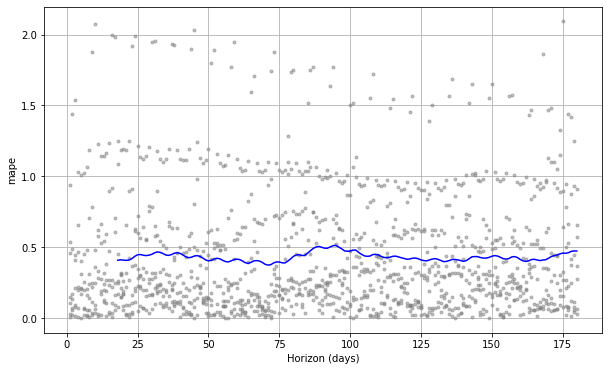

In [16]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

# Hyperparameter tuning 

In [62]:
param_grid = {
    'changepoint_prior_scale': [0.005, 0.05, 0.5, 5],
    'changepoint_range': [0.8, 0.9],
    'seasonality_prior_scale':[0.1, 1, 10.0],
    'holidays_prior_scale':[0.1, 1, 10.0],
    'seasonality_mode': ['multiplicative', 'additive'],
    'growth': ['linear', 'logistic'],
    'yearly_seasonality': [5, 10, 20]
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# Use cross validation to evaluate all parameters
results = []
for params in all_params:
    m = Prophet(**params) 
    m.add_country_holidays(country_name='US')
    m.fit(df)
    df_cv = cross_validation(m, initial='360 days', period='90 days', horizon = '180 days', parallel="dask")
    df_p = performance_metrics(df_cv, rolling_window=1)
    df_p['params'] = str(params)
    results.append(df_p)

results_df = pd.concat(results)
    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:63659' processes=4 threads=8, memory=17.18 GB>
INFO:fbprophet:Disabling daily seasonality. Run prophet

In [109]:
# Find the best parameters
best_param = results_df.loc[results_df['mape'] == min(results_df['mape']), ['params']]
print(f'The best param combination is {best_param.values[0][0]}')


The best param combination is {'changepoint_prior_scale': 0.005, 'changepoint_range': 0.9, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'growth': 'linear', 'yearly_seasonality': 20}


# New model

In [20]:
m= Prophet(
    changepoint_prior_scale=0.005,
    changepoint_range=0.9,
    seasonality_prior_scale=0.1,
    holidays_prior_scale= 0.1,
    seasonality_mode='multiplicative',
    growth='linear', 
    yearly_seasonality= 20
)
m.add_country_holidays(country_name='US')

m.fit(df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


INFO:fbprophet:Making 7 forecasts with cutoffs between 2019-01-11 00:00:00 and 2020-07-04 00:00:00
INFO:fbprophet:Applying in parallel with <Client: 'tcp://127.0.0.1:52712' processes=8 threads=8, memory=17.18 GB>


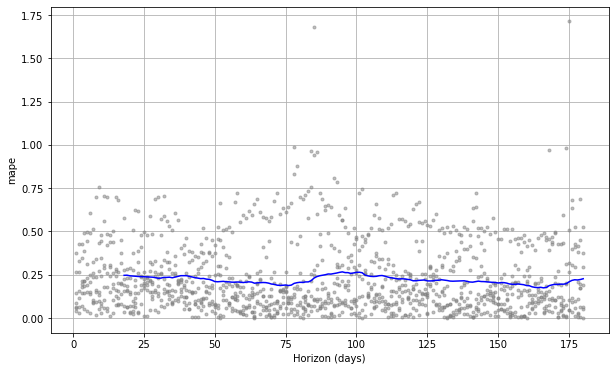

In [21]:
df_cv = cross_validation(m, initial='360 days', period='90 days', horizon = '180 days', parallel='dask')
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [22]:
future = m.make_future_dataframe(periods=180) 
forecast = m.predict(future)

plot_plotly(m, forecast)


In [24]:
plot_components_plotly(m, forecast)

 
References:

https://peerj.com/preprints/3190/

https://facebook.github.io/prophet/

https://examples.dask.org/applications/forecasting-with-prophet.html

http://neuralprophet.com/
